# Importing Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [2]:
import classes.file_loader as file_loader
import classes.linear_time_series as linear_time_series
import classes.tools as tools
import classes.gated_reccurent_unit as gated_reccurent_unit 

# Data Preprocessing

## Loading Files

In [3]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [4]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  classic_raw_df.fillna(method = "ffill", inplace=True)
c:\Users\PC FIXE HUGO\Documents\Time_series_Prediction\classes\file_loader.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  precarity_raw_df.fillna(method = "ffill", inplace=True)


In [5]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [6]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [7]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.206606
2,2023-04-26,7.248862
3,2023-04-27,7.269627
4,2023-04-28,7.256932
...,...,...
446,2025-01-07,7.965656
447,2025-01-08,7.967767
448,2025-01-09,7.997226
449,2025-01-10,7.987875


In [8]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.320920
2,2023-04-26,7.342658
3,2023-04-27,7.329170
4,2023-04-28,7.384121
...,...,...
446,2025-01-07,10.153100
447,2025-01-08,9.838458
448,2025-01-09,10.146411
449,2025-01-10,10.402918


## Plotting the selected augmented dataframes 

We select one iteration of fir the classic and precarirty dataframe.

In [9]:
classic_df = pd.read_csv("selected_augmented_classic_df.csv")
precarity_df = pd.read_csv("selected_augmented_precarity_df.csv")

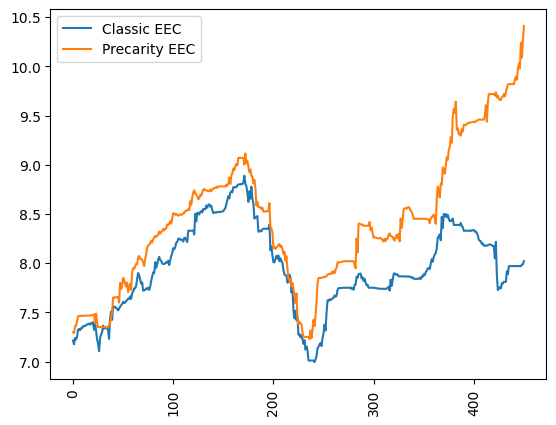

In [10]:
plt.figure()

plt.plot(classic_df["SPOT"], label = "Classic EEC")
plt.plot(precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

# Data forecasting

## Classic EEC

### ARMA

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [11]:
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.174503,-0.038213
2,2023-04-26,7.238924,0.064421
3,2023-04-27,7.224501,-0.014423
4,2023-04-28,7.249729,0.025228
5,2023-05-01,7.321166,0.071437
...,...,...,...
446,2025-01-07,7.969759,-0.000241
447,2025-01-08,7.969839,0.000079
448,2025-01-09,7.986663,0.016825
449,2025-01-10,7.988577,0.001914


In [12]:
result = adfuller(classic_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 7.099464000429687e-17
Result: reject unit root -> series is stationary (at 5% level).


We create an ARMA model (in reality ARIMA as the series wwas already differentiated), using a class built on our own.

In [13]:
# Initiate the ARMA class

LineaTimeSeriesModel = linear_time_series.LineaTimeSeriesModel(classic_df["Delta"])

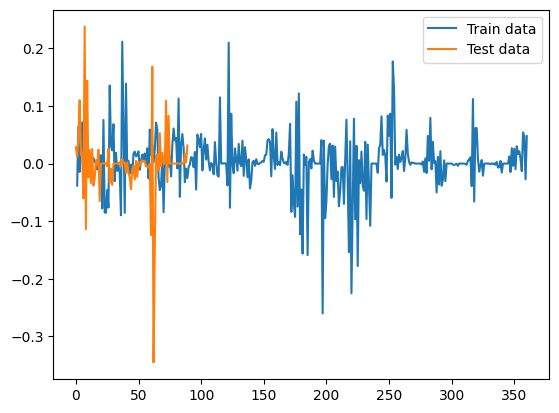

In [14]:
#Spltting the data into train and test sets

LineaTimeSeriesModel.train_test_split()

plt.figure()
plt.plot(LineaTimeSeriesModel.train_dependent, label="Train data")
plt.plot(LineaTimeSeriesModel.test_dependent, label="Test data")
plt.legend()
plt.show()

In [15]:
# Selecting the last relevant lags

ma_max_order = LineaTimeSeriesModel.get_ma_max_order()
ar_max_order = LineaTimeSeriesModel.get_ar_max_order()
print(f"Max MA order: {ma_max_order}, Max AR order: {ar_max_order}")

Max MA order: 2, Max AR order: 3


In [16]:
# Selecting the best model according to AIC using the maximum relevant lags

warnings.filterwarnings("ignore")

selected_models = LineaTimeSeriesModel.select_model(ma_max_order, ar_max_order)
selected_models["aic"]

The p-value of the L-JungBox test is 5.452188889542694e-05 for the model ARIMA(0,0,0) with AIC = -1144.3101721781136
The p-value of the L-JungBox test is 7.570545478104549e-06 for the model ARIMA(1,0,0) with AIC = -1150.243170534036
The p-value of the L-JungBox test is 0.05929499623878176 for the model ARIMA(2,0,0) with AIC = -1160.409358050496
The p-value of the L-JungBox test is 0.6256113965714318 for the model ARIMA(3,0,0) with AIC = -1166.9177317642766
The p-value of the L-JungBox test is 1.6148356721592134e-05 for the model ARIMA(0,0,1) with AIC = -1147.9394708034883
The p-value of the L-JungBox test is 7.367106984500183e-05 for the model ARIMA(1,0,1) with AIC = -1152.116042331536
The p-value of the L-JungBox test is 0.8410019826228228 for the model ARIMA(2,0,1) with AIC = -1167.1334826325115
The p-value of the L-JungBox test is 0.8983060419302107 for the model ARIMA(3,0,1) with AIC = -1168.2148079677158
The p-value of the L-JungBox test is 0.15325935502114954 for the model ARIMA(

{'order': (3, 0, 1),
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x26ef40a92b0>,
 'aic': np.float64(-1168.2148079677158)}

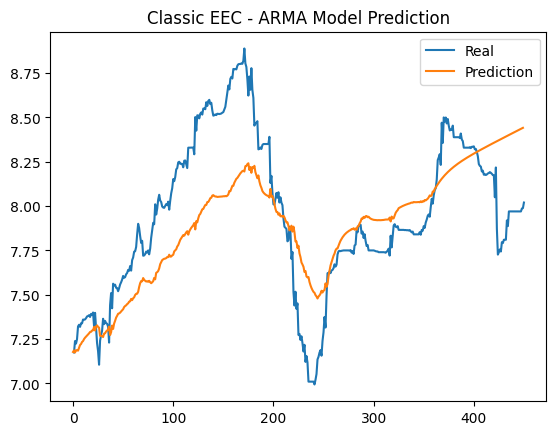

In [17]:
# Prediction using our model
train_pred, test_pred = LineaTimeSeriesModel.model_prediction(selected_models["aic"]["model"])
prediction = np.concatenate([train_pred, test_pred])

# Cumulative sum to get back to the original scale
cum_train_pred = np.cumsum(train_pred) + classic_df["SPOT"].iloc[0]
cum_test_pred = np.cumsum(test_pred) + cum_train_pred.iloc[-1]
cum_prediction = np.cumsum(prediction) + classic_df["SPOT"].iloc[0]

plt.figure()
plt.title("Classic EEC - ARMA Model Prediction")
plt.plot(classic_df["SPOT"], label="Real")
plt.plot(cum_prediction, label="Prediction")
plt.legend()
plt.show()

In [18]:
# Asssessing performances of ARIMA model
arima_model_metrics = tools.model_metrics(LineaTimeSeriesModel.train_dependent, cum_train_pred, LineaTimeSeriesModel.test_dependent, cum_test_pred)

all_metrics = arima_model_metrics.get_all_metrics()
all_metrics

{'train': {'mae': 7.786654627825624,
  'rmse': 7.790191792810022,
  'mape': inf,
  'r2': -25109.581920015124},
 'test': {'mae': nan, 'rmse': 8.299682911328302, 'mape': nan, 'r2': 1.0}}

### RNN

Neural Networks do not necessarily need stationnary data. However they perform better on normalized data. Hence we create the normalized data using normal distribution :

In [19]:
standard_scaler = MinMaxScaler()
classic_df["Normalized Spot"] = standard_scaler.fit_transform(classic_df[["SPOT"]])
classic_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


#### GRU

Parameters to optimize :
-   Lookback : Number of points used to predict the next oneNombre de points utilisés pour prédire le point suivant
-   Hidden size : Number of GRU cells per layer
-   Number of layers : Number of layers
-   Lambda or regularization parameter : the parameter used in L2 Regularization 

*NB : After having conducted many tests 1 layer seems to provide better results than 2 layers*

In [20]:
# Initializing the GRU class

GRU = gated_reccurent_unit.GRU(classic_df["Normalized Spot"], epochs=40, lr=0.001, train_test_ratio=0.8)
param_grid = {
    "lookback": [int(x) for x in np.linspace(10,100,10)],
    "hidden_size": [2, 4, 8, 16],
    "num_layers": [1, 2],
    "l2": [0.0, 1e-4, 1e-3, 1e-2]
}

In [ ]:
# Training estimation
original_set_parameters_to_test = 18
original_elasped_time = 7.9 #seconds

set_parameters_to_test = len(param_grid["lookback"]) * len(param_grid["hidden_size"]) * len(param_grid["num_layers"]*  len(param_grid["l2"]))
elasped_time = (original_elasped_time / original_set_parameters_to_test) * set_parameters_to_test
print(f"Estimated training time with current grid search: {elasped_time:.2f} seconds.")

Estimated training time with current grid search: 35.11 seconds.


In [22]:
GRU.tune(param_grid)

lookback=10, hidden=2, layers=1, l2=0.0 → MSE=0.003865
lookback=10, hidden=2, layers=1, l2=0.0001 → MSE=0.767422
lookback=10, hidden=2, layers=1, l2=0.001 → MSE=0.001358
lookback=10, hidden=2, layers=1, l2=0.01 → MSE=0.785205
lookback=10, hidden=2, layers=2, l2=0.0 → MSE=0.003842
lookback=10, hidden=2, layers=2, l2=0.0001 → MSE=0.056968
lookback=10, hidden=2, layers=2, l2=0.001 → MSE=1.202347
lookback=10, hidden=2, layers=2, l2=0.01 → MSE=0.364553
lookback=10, hidden=4, layers=1, l2=0.0 → MSE=0.689640
lookback=10, hidden=4, layers=1, l2=0.0001 → MSE=0.180301
lookback=10, hidden=4, layers=1, l2=0.001 → MSE=0.005411
lookback=10, hidden=4, layers=1, l2=0.01 → MSE=0.362589
lookback=10, hidden=4, layers=2, l2=0.0 → MSE=0.001444
lookback=10, hidden=4, layers=2, l2=0.0001 → MSE=0.001412
lookback=10, hidden=4, layers=2, l2=0.001 → MSE=0.259836
lookback=10, hidden=4, layers=2, l2=0.01 → MSE=0.002127
lookback=10, hidden=8, layers=1, l2=0.0 → MSE=0.001875
lookback=10, hidden=8, layers=1, l2=0.000

In [23]:
preds, true = GRU.predict("test")
print(f"Preds: {preds}, True: {true}")

Preds: [0.5099718  0.51102805 0.51150674 0.5200161  0.5220084  0.52916145
 0.5328071  0.5345926  0.5354489  0.53585446 0.53604454 0.53613245
 0.5361722  0.5361894  0.5361961  0.53619826 0.5361804  0.53617656
 0.5374311  0.53821176], True: [0.43092766 0.43062362 0.48820832 0.47133906 0.51509091 0.51509091
 0.51509091 0.51509091 0.51509091 0.51509091 0.51509091 0.51509091
 0.51509091 0.51509091 0.51509091 0.51496396 0.51500574 0.52388493
 0.52489487 0.54147839]


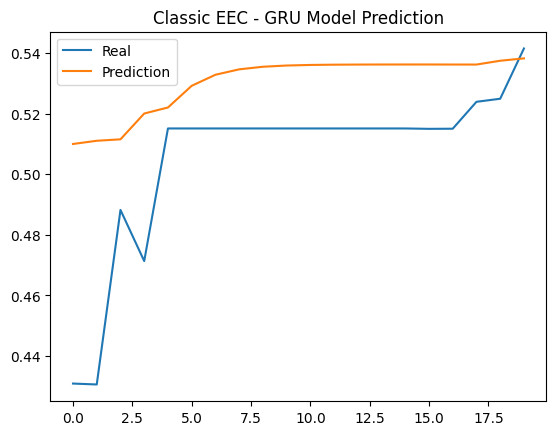

In [24]:
plt.figure()
plt.title("Classic EEC - GRU Model Prediction")
plt.plot(true, label="Real")
plt.plot(preds, label="Prediction")
plt.legend()
plt.show()

#### LSTM